# Working with the rest of the labels

In the main notebook we have worked with the exciting label; explaining carefully the steps we have followed in order to find the best solution (with the PCAs features). 

In this way this notebook have the intention to find a model with the PCA features for every one of the given labels based on the previous steps which have been done in the main notebook. (If you are looking to explanations or reasons we refers to the other notebook).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
import joblib
%matplotlib inline

In [2]:
DATA_FOLDER = './data/' #The data is in the .gitignore in order to not upload it to the GitHub repository
VIS_FOLDER = './visualizations/' #Folder where save the visualizations
MODELS_FOLDER = './sklearn_models/'

In [3]:
label_list = ['pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious']
LIMIT = 7  ## Change this variable for working with the percentage of people how felt more than LIMIT-excited
COUNTRY = "Greece"  #You can change it to Switzerland

### Loading phase

In [4]:
df_ml = pd.read_parquet(DATA_FOLDER + "original_data.parquet")

In this notebook we are going to use the PCA features, so we can remove the others from the data frame:

In [5]:
df_ml = df_ml[['Country', 'Pattern', 'Context', 'SkyType','pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious']]
df_ml.head(2)

,Country,Pattern,Context,SkyType,pleasant,interesting,exciting,calming,complex,bright,view,spacious
0,Greece,P1EL,social,clearhigh,7,5,5,7,0,7,6,9
1,Greece,P1EL,social,clearhigh,5,4,4,7,3,8,5,10


In [6]:
fdata = df_ml.iloc[:,0:4] #fdata -> first data without preprocessing
fdata.drop_duplicates(inplace = True)
fdata.set_index(['Country', 'Pattern', 'Context', 'SkyType'], inplace = True)


computing_percentages_total_df = df_ml[['Country', 'Pattern', 'Context', 'SkyType']].copy()
computing_percentages_total_df["Total_people"] = 0
computing_percentages_total_df = computing_percentages_total_df.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

perc_list_names = []
for label in label_list:
    percentage_name = "Percentage_" + label
    perc_list_names = perc_list_names + [percentage_name]
    
    df_ml_over_limit = df_ml[df_ml[label] >= LIMIT]
    computing_percentages_df2 = df_ml_over_limit[['Country', 'Pattern', 'Context', 'SkyType']].copy()
    computing_percentages_df2["People_who_felt_label_feeling"] = 0
    computing_percentages_df2 = computing_percentages_df2.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()
    
    computing_percentages_joined = pd.DataFrame.join(computing_percentages_total_df, computing_percentages_df2).fillna(value=0)
    
    fdata = fdata.join(computing_percentages_joined)
    fdata[percentage_name] = fdata["People_who_felt_label_feeling"] / fdata["Total_people"]
    fdata = fdata.drop(columns = ["People_who_felt_label_feeling", "Total_people"])
    
#fdata.reset_index(inplace = True)

In [7]:
fdata.head(2)

,,,,Percentage_pleasant,Percentage_interesting,Percentage_exciting,Percentage_calming,Percentage_complex,Percentage_bright,Percentage_view,Percentage_spacious
Country,Pattern,Context,SkyType,,,,,,,,
Greece,P1EL,social,clearhigh,0.333333,0.095238,0.047619,0.333333,0.0,0.47619,0.333333,0.857143
Switzerland,P1EL,social,clearhigh,0.300000,0.150000,0.000000,0.300000,0.0,0.30000,0.300000,0.600000


Load a data frame with the compressed image pixels:

In [8]:
pixels_excited_df = pd.read_parquet(DATA_FOLDER + "pixels_compressed.parquet")
pixels_excited_df.reset_index(inplace = True)
pixels_excited_df.set_index(['Country', 'Pattern', 'Context', 'SkyType'], inplace = True)

In [9]:
pixels_for_PCA = pixels_excited_df.drop(columns = "Percentage_excited_people")

In [10]:
pixels_for_PCA.head(3)

,,,,img_array
Country,Pattern,Context,SkyType,
Greece,P1EL,social,clearhigh,"[103.0, 103.125, 103.84722222222221, 103.95833..."
Switzerland,P1EL,social,clearhigh,"[103.0, 103.125, 103.84722222222221, 103.95833..."
Greece,P1EL,social,clearlow,"[110.0, 110.0, 110.54166666666667, 111.0, 111...."


Finally, having a data frame with the percentages and another data frame with the compressed images pixels we join them:

In [11]:
pca_df = pd.DataFrame.join(pixels_for_PCA, fdata)
pca_df.reset_index(inplace = True)
pca_df.set_index(['Pattern', 'Context', 'SkyType'], inplace = True)
pca_df.head(2)

Country  \
Pattern Context SkyType                  
P1EL    social  clearhigh       Greece   
                clearhigh  Switzerland   

                                                                   img_array  \
Pattern Context SkyType                                                        
P1EL    social  clearhigh  [103.0, 103.125, 103.84722222222221, 103.95833...   
                clearhigh  [103.0, 103.125, 103.84722222222221, 103.95833...   

                           Percentage_pleasant  Percentage_interesting  \
Pattern Context SkyType                                                  
P1EL    social  clearhigh             0.333333                0.095238   
                clearhigh             0.300000                0.150000   

                           Percentage_exciting  Percentage_calming  \
Pattern Context SkyType                                              
P1EL    social  clearhigh             0.047619            0.333333   
                clearhigh             0.000000            0.300000   

                           Percentage_complex  Percentage_bright  \
Pattern Context SkyType                                            
P1EL    social  clearhigh                 0.0            0.47619   
                clearhigh                 0.0            0.30000   

                           Percentage_view  Percentage_spacious  
Pattern Context SkyType                                          
P1EL    social  clearhigh         0.333333             0.857143  
                clearhigh         0.300000             0.600000

## PCA and ridge regression for every label:

Note that the name of the variables have the subfixe _greece but if you have change the COUNTRY variable at the beginning, the program will work with the given country.

In [12]:
pixels_labels_greece = pca_df[pca_df["Country"]==COUNTRY]

#The pixels are the same for Greece and for Switzerland, since the images are the same ones
x_matrix_temp = [pixels_array.tolist() for pixels_array in pixels_labels_greece["img_array"].values]

In [13]:
### Preparing Matrices
X_greece = x_matrix_temp
y_greece = pixels_labels_greece[perc_list_names]

#X_digits_switz = x_matrix_temp_switz
#y_digits_switz = pixels_switz[labels].values

## Standardize
X_greece = preprocessing.scale(X_greece)


## Pol expansion (in our case add a constant (bias)) for all data
#pol = PolynomialFeatures(1, True, True)
#phX_greece = pol.fit_transform(X_greece, y_digits_greece)
#phx_greece = X_greece # for no pol

## Splitting of the data
X_train_greece, X_test_greece, y_train_greece, y_test_greece = train_test_split(X_greece, y_greece, test_size=0.2, random_state=0)

In [21]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('rig_reg', Ridge(solver="lsqr"))])

#Parameters for the PCA and the Ridge during the GridSearch:
PCA_n_comp = np.arange(8, 22)  #(1,28) # must be between 0 and min(n_samples, n_features)=n_samples=len(X_train)=28
lambdas = np.logspace(2, 5, 20) + [13895]  #13895 lambda which gave the best results with the 'exciting' label

## Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {'pca__n_components': PCA_n_comp, 'rig_reg__alpha': lambdas}

In [22]:
search_greece = []
for i in range(len(label_list)):
    #Grid search will take by default the estimator's default scorer, i.e. the least squares from ridge regression estimator
    search_greece = search_greece + [GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=True, scoring = 'neg_mean_absolute_error')] 
    
    ## Modeling
    search_greece[i].fit(X_train_greece, y_train_greece[perc_list_names[i]].values)

In [32]:
test_errors =[]
for i in range(len(label_list)):
    print("LABEL: " ,label_list[i])
    ## Modeling
    print("\tBest parameters set found on development set: \n\t", search_greece[i].best_params_)
    test_errors = test_errors + [sum(abs(search_greece[i].predict(X_test_greece)-y_test_greece[perc_list_names[i]]))/len(X_test_greece[:,0])]
    print("\tTest error:\n\t", test_errors[i])
    model_name = "grid_pca_ridge_label" + label_list[i]
    
    
    #joblib.dump(search_greece[i], MODELS_FOLDER + model_name + '.pkl')
    

LABEL:  pleasant
	Best parameters set found on development set: 
	 {'pca__n_components': 18, 'rig_reg__alpha': 13995.0}
	Test error:
	 0.09828181572019827
LABEL:  interesting
	Best parameters set found on development set: 
	 {'pca__n_components': 8, 'rig_reg__alpha': 19350.594781168515}
	Test error:
	 0.10792221355421217
LABEL:  exciting
	Best parameters set found on development set: 
	 {'pca__n_components': 12, 'rig_reg__alpha': 13995.0}
	Test error:
	 0.06499460396164893
LABEL:  calming
	Best parameters set found on development set: 
	 {'pca__n_components': 20, 'rig_reg__alpha': 13995.0}
	Test error:
	 0.09268743236861453
LABEL:  complex
	Best parameters set found on development set: 
	 {'pca__n_components': 18, 'rig_reg__alpha': 13995.0}
	Test error:
	 0.09992859532753519
LABEL:  bright
	Best parameters set found on development set: 
	 {'pca__n_components': 8, 'rig_reg__alpha': 113895.0}
	Test error:
	 0.12941175256826185
LABEL:  view
	Best parameters set found on development set: 


### Visualization: of the best results

In [37]:
labels_errors = pd.DataFrame(label_list, columns = ["labels"])
labels_errors["errors"] = test_errors

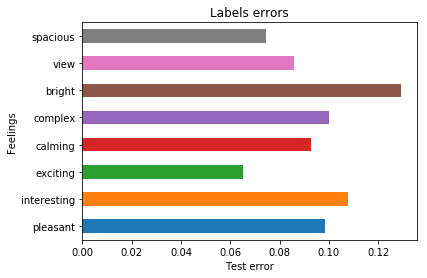

In [41]:
labels_errors.plot(kind='barh',x='labels',y='errors',legend=None);
plt.title('Labels errors');
plt.xlabel('Test error');
plt.ylabel('Feelings');
plt.savefig(VIS_FOLDER + 'labels_errors.png', bbox_inches='tight')